# **Mounting Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Loading the Libraries**

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import numpy as np
import os
import math
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras as keras
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Reshape, Dense, LSTM, add, concatenate, Dropout, Lambda, Flatten
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Reshape, Permute
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.layers.recurrent import GRU, LSTM
import keras.backend as K

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


# **Cleaning DataFrame and creating dataset**

In [3]:
audio_path="/content/drive/MyDrive/Colab Notebooks/SummerProject/"
json_path=audio_path+"data.json"

In [4]:
df=pd.read_csv(audio_path+"audio/meta.csv", sep="\t")
df

,filename,scene_label,identifier,source_label
0,audio/airport-lisbon-1000-40000-a.wav,airport,lisbon-1000,a
1,audio/airport-prague-1015-40019-a.wav,airport,prague-1015,a
2,audio/airport-prague-1023-40027-a.wav,airport,prague-1023,a
3,audio/airport-prague-1023-40038-a.wav,airport,prague-1023,a
4,audio/airport-prague-1034-40041-a.wav,airport,prague-1034,a
...,...,...,...,...
23030,audio/tram-barcelona-181-5627-s6.wav,tram,barcelona-181,s6
23031,audio/tram-helsinki-184-5724-s6.wav,tram,helsinki-184,s6
23032,audio/tram-lisbon-1100-43586-s6.wav,tram,lisbon-1100,s6
23033,audio/tram-london-188-5815-s6.wav,tram,london-188,s6


In [5]:
df=df.drop('identifier', axis=1)
df=df.drop("source_label",axis=1)
df

,filename,scene_label
0,audio/airport-lisbon-1000-40000-a.wav,airport
1,audio/airport-prague-1015-40019-a.wav,airport
2,audio/airport-prague-1023-40027-a.wav,airport
3,audio/airport-prague-1023-40038-a.wav,airport
4,audio/airport-prague-1034-40041-a.wav,airport
...,...,...
23030,audio/tram-barcelona-181-5627-s6.wav,tram
23031,audio/tram-helsinki-184-5724-s6.wav,tram
23032,audio/tram-lisbon-1100-43586-s6.wav,tram
23033,audio/tram-london-188-5815-s6.wav,tram


In [6]:
dur=[]
siz=df['filename'].size
ct=0
for i in range (0,siz) :
  fn=audio_path+df.iloc[i][0]
  # print(fn)
  if os.path.isfile(fn):
   dur.insert(i,10)
   ct=ct+1
  else:
   dur.insert(i,-1)
   

df["length"]=dur
df=df[df["length"]!=-1]

(-1.1046890795467796,
 1.1039731272721134,
 -1.1046087032328278,
 1.100219462058706)

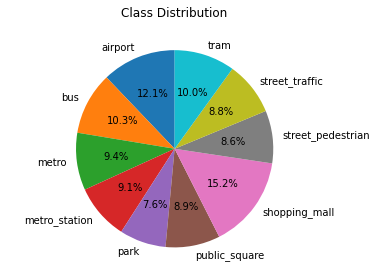

In [7]:
class_dist=df.groupby(['scene_label'])['length'].size()

fig,ax=plt.subplots()
ax.set_title("Class Distribution", y=1.08)
ax.pie(class_dist,labels=class_dist.index,autopct="%1.1f%%", shadow=False,startangle=90)
ax.axis('equal')


In [ ]:
def save_mfcc(audio_path,data_frame,json_path, n_mfcc=13, n_fft=2048, hop_length=512,num_segments=10):
  mp=["airport","tram","bus","park","metro","metro_station","public_square","shopping_mall","street_pedestrian","street_traffic"]
  sample_rate=44100
  duration=10
  num_samples_per_segment=int((duration*sample_rate)/num_segments)
  expected_mfcc=math.ceil(num_samples_per_segment/hop_length)

  data={
      "mapping": mp,
      "mfcc": [],
      "labels": []
  }
  num_data=data_frame['filename'].size
  for i in range(0,num_data):
    semantic_label=data_frame.iloc[i][1]
    file_path=audio_path+df.iloc[i][0]
    signal,sr=librosa.load(file_path,sr=sample_rate)
    for s in range(num_segments):
      start_sample=int(num_samples_per_segment*s)
      end_sample=int(start_sample+num_samples_per_segment)
      mfcc=librosa.feature.mfcc(signal[start_sample:end_sample],
                                sr=sample_rate,
                                n_fft=n_fft,
                                n_mfcc=n_mfcc,
                                hop_length=hop_length).T
      if len(mfcc)==expected_mfcc:
        data["mfcc"].append(mfcc.tolist())
        data["labels"].append(mp.index(semantic_label))
  
  with open(json_path,"w") as fp:
    json.dump(data,fp,indent=4)


# save_mfcc(audio_path,df,json_path, n_mfcc=13, n_fft=2048, hop_length=512,num_segments=10)

      


In [9]:
def plot_history(history):

  fig,axs=plt.subplots(2)

  # Accuracy Subplot
  axs[0].plot(history.history["accuracy"],label="train accuracy")
  axs[0].plot(history.history["val_accuracy"],label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy Eval")

  # Error Subplot
  axs[1].plot(history.history["loss"],label="train error")
  axs[1].plot(history.history["val_loss"],label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error Eval")
  
  plt.show()

# **Loading Data**

In [8]:
def load_data(dataset_path):
  with open( dataset_path,"r") as fp:
    data=json.load(fp)

  inputs=np.array(data["mfcc"])
  targets=np.array(data["labels"])
  return inputs,targets
inputs,targets=load_data(json_path)

# **Functions to do prediction**

In [25]:
def get_mfcc_sample(sample,n_mfcc=13, n_fft=2048, hop_length=512,num_segments=10):
  sample,sample_rate=librosa.load(sample,sr=44100)
  duration=10
  num_samples_per_segment=int((duration*sample_rate)/num_segments)
  expected_mfcc=math.ceil(num_samples_per_segment/hop_length)
  sample_mfcc=[]

  for s in range(num_segments):
      start_sample=int(num_samples_per_segment*s)
      end_sample=int(start_sample+num_samples_per_segment)
      mfcc=librosa.feature.mfcc(sample[start_sample:end_sample],
                                sr=sample_rate,
                                n_fft=n_fft,
                                n_mfcc=n_mfcc,
                                hop_length=hop_length).T
      # if len(mfcc)==expected_mfcc:
      sample_mfcc.append(mfcc.tolist())
  return sample_mfcc
  
def predict_sample(sample,model):
  sample_data_mfcc=np.array(get_mfcc_sample(sample, n_mfcc=13, n_fft=2048, hop_length=512,num_segments=10))
  mp=["airport","tram","bus","park","metro","metro_station","public_square","shopping_mall","street_pedestrian","street_traffic"]
  results=model.predict(sample_data_mfcc)
  val=[0]*10

  for i in range(9):
   val[np.argmax(results[i])]+=1
  print(mp[np.argmax(val)])


# **Creating A 1D CNN model**

In [11]:
def create_model(input_shape):
  model=keras.Sequential([
  #Input Layer
  keras.layers.Flatten(input_shape=(inputs.shape[1],inputs.shape[2])),

  #1st Hidden Layer
  keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001)),
  keras.layers.Dropout(0.3),

  #2nd Hidden Layer
  keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001)),
  keras.layers.Dropout(0.3),

  #3rd Hidden Layer
  keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001)),
  keras.layers.Dropout(0.3),
  
  #Output Layer
  keras.layers.Dense(10, activation="softmax")

  ])



  optimizer=keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]
              )
  return model

Epoch 1/50
226/226 [==============================] - 5s 6ms/step - loss: 38.1260 - accuracy: 0.1276 - val_loss: 2.4155 - val_accuracy: 0.1742
Epoch 2/50
226/226 [==============================] - 1s 4ms/step - loss: 5.3509 - accuracy: 0.1560 - val_loss: 2.2116 - val_accuracy: 0.2602
Epoch 3/50
226/226 [==============================] - 1s 4ms/step - loss: 3.0339 - accuracy: 0.1730 - val_loss: 2.1129 - val_accuracy: 0.3038
Epoch 4/50
226/226 [==============================] - 1s 5ms/step - loss: 2.5141 - accuracy: 0.1816 - val_loss: 2.1880 - val_accuracy: 0.3079
Epoch 5/50
226/226 [==============================] - 1s 5ms/step - loss: 2.3402 - accuracy: 0.2125 - val_loss: 2.1006 - val_accuracy: 0.3484
Epoch 6/50
226/226 [==============================] - 1s 4ms/step - loss: 2.2564 - accuracy: 0.2484 - val_loss: 2.0318 - val_accuracy: 0.3681
Epoch 7/50
226/226 [==============================] - 1s 5ms/step - loss: 2.1994 - accuracy: 0.2741 - val_loss: 1.9537 - val_accuracy: 0.3940
Epoch

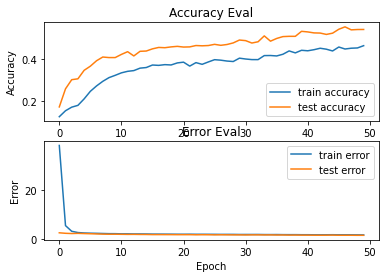

In [12]:
inputs_train,inputs_test,targets_train,targets_test=train_test_split(inputs,targets,test_size=0.3)
inputs_train,inputs_validation,targets_train,targets_validation=train_test_split(inputs_train,targets_train,test_size=0.2)
input_shape=(inputs_train.shape[1],inputs_train.shape[2])

model_1DCNN=create_model(input_shape)
history=model_1DCNN.fit(inputs_train,targets_train,
          validation_data=(inputs_test,targets_test),
          epochs=50,
          batch_size=32,
          )

plot_history(history)

# **Creating A 2D CNN model**

In [13]:
def Lenet(inputs_shape):
  
    model = keras.models.Sequential([
                                     
    keras.layers.Conv2D(6, kernel_size=3, strides=1,  activation='relu', input_shape=inputs_shape, padding='same'), #C1

    keras.layers.AveragePooling2D(), #S2

    keras.layers.Conv2D(16, kernel_size=3, strides=1, activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)), #C3
    keras.layers.Dropout(0.3),

    keras.layers.AveragePooling2D(), #S4

    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)), #C5
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(), #Flatten

    keras.layers.Dense(84, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)), #F6
    
    keras.layers.Dense(10, activation='softmax') #Output layer
    ])
    optimizer=keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]
              )
    return model

Epoch 1/50
226/226 [==============================] - 11s 7ms/step - loss: 2.3493 - accuracy: 0.2290 - val_loss: 1.8556 - val_accuracy: 0.3409
Epoch 2/50
226/226 [==============================] - 1s 5ms/step - loss: 1.8251 - accuracy: 0.3554 - val_loss: 1.6302 - val_accuracy: 0.4209
Epoch 3/50
226/226 [==============================] - 1s 5ms/step - loss: 1.6634 - accuracy: 0.4109 - val_loss: 1.5132 - val_accuracy: 0.4703
Epoch 4/50
226/226 [==============================] - 1s 5ms/step - loss: 1.5585 - accuracy: 0.4441 - val_loss: 1.4420 - val_accuracy: 0.4792
Epoch 5/50
226/226 [==============================] - 1s 5ms/step - loss: 1.4827 - accuracy: 0.4791 - val_loss: 1.3753 - val_accuracy: 0.5214
Epoch 6/50
226/226 [==============================] - 1s 5ms/step - loss: 1.4062 - accuracy: 0.5099 - val_loss: 1.3199 - val_accuracy: 0.5441
Epoch 7/50
226/226 [==============================] - 1s 5ms/step - loss: 1.3473 - accuracy: 0.5255 - val_loss: 1.2679 - val_accuracy: 0.5602
Epoch

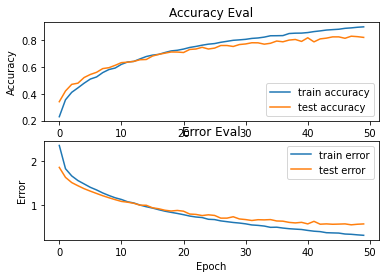

In [14]:
inputs_train,inputs_test,targets_train,targets_test=train_test_split(inputs,targets,test_size=0.3)
inputs_train,inputs_validation,targets_train,targets_validation=train_test_split(inputs_train,targets_train,test_size=0.2)
inputs_train=inputs_train[...,np.newaxis]
inputs_test=inputs_test[...,np.newaxis]
inputs_validation=inputs_validation[...,np.newaxis]
inputs_shape=(inputs_train.shape[1],inputs_train.shape[2],inputs_train.shape[3])

model_2DCNN=Lenet(inputs_shape)

history=model_2DCNN.fit(inputs_train,targets_train,
          validation_data=(inputs_validation,targets_validation),
          epochs=50,
          batch_size=32,
          )
plot_history(history)

# **Creating A RNN LSTM model**

In [23]:
def create_model(input_shape):
  model=keras.models.Sequential()

  model.add(keras.layers.LSTM(64,input_shape=input_shape,return_sequences=True))
  model.add(keras.layers.LSTM(64))

  model.add(keras.layers.Dense(64,activation="relu"))
  model.add(keras.layers.Dropout(0.3))

  model.add(keras.layers.Dense(10,activation="softmax"))
  
  optimizer=keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]
              )

  return model

Epoch 1/50
451/451 [==============================] - 11s 18ms/step - loss: 2.2126 - accuracy: 0.1958 - val_loss: 2.0571 - val_accuracy: 0.2798
Epoch 2/50
451/451 [==============================] - 6s 14ms/step - loss: 1.9774 - accuracy: 0.3005 - val_loss: 1.8418 - val_accuracy: 0.3443
Epoch 3/50
451/451 [==============================] - 5s 11ms/step - loss: 1.7737 - accuracy: 0.3812 - val_loss: 1.6691 - val_accuracy: 0.4153
Epoch 4/50
451/451 [==============================] - 5s 11ms/step - loss: 1.6229 - accuracy: 0.4381 - val_loss: 1.5125 - val_accuracy: 0.4714
Epoch 5/50
451/451 [==============================] - 7s 15ms/step - loss: 1.5206 - accuracy: 0.4712 - val_loss: 1.4381 - val_accuracy: 0.4942
Epoch 6/50
451/451 [==============================] - 6s 13ms/step - loss: 1.4673 - accuracy: 0.4881 - val_loss: 1.3630 - val_accuracy: 0.5164
Epoch 7/50
451/451 [==============================] - 5s 11ms/step - loss: 1.4012 - accuracy: 0.5174 - val_loss: 1.3401 - val_accuracy: 0.541

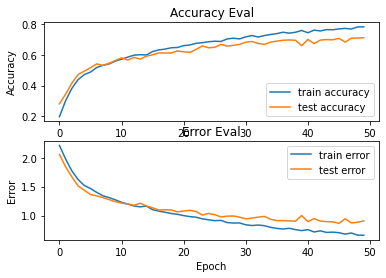

In [18]:
inputs_train,inputs_test,targets_train,targets_test=train_test_split(inputs,targets,test_size=0.3)
inputs_train,inputs_validation,targets_train,targets_validation=train_test_split(inputs_train,targets_train,test_size=0.2)
input_shape=(inputs_train.shape[1],inputs_train.shape[2])

model_RNN=create_model(input_shape)

history=model_RNN.fit(inputs_train,targets_train,
          validation_data=(inputs_validation,targets_validation),
          batch_size=16,
          epochs=50,
          )

plot_history(history)


# **Creating A CRNN model**

In [20]:
def CRNN2D(input_shape):

    nb_layers = 3  # number of convolutional layers
    nb_filters = [64, 128, 128, 128]  # filter sizes
    kernel_size = (3, 3)  # convolution kernel size
    activation = 'relu'  # activation function to use after each layer
    pool_size = [(2, 2), (2, 2), (2, 2), (2, 2),
                 (2, 2)]  # size of pooling area

    # shape of input data (frequency, time, channels)
    input_shape = input_shape
    frequency_axis = 1
    time_axis = 2
    channel_axis = 3

    # Create sequential model and normalize along frequency axis
    model = keras.models.Sequential()
    model.add(BatchNormalization(axis=frequency_axis, input_shape=input_shape))

    # First convolution layer specifies shape
    model.add(Conv2D(nb_filters[0], kernel_size=kernel_size, padding='same',
                     data_format="channels_last",
                     input_shape=input_shape,
                     kernel_regularizer=keras.regularizers.l2(0.0001)))
    model.add(Activation(activation))
    model.add(BatchNormalization(axis=channel_axis))
    model.add(MaxPooling2D(pool_size=pool_size[0], strides=pool_size[0]))
    model.add(Dropout(0.3))

    # Add more convolutional layers
    for layer in range(nb_layers - 1):
        # Convolutional layer
        model.add(Conv2D(nb_filters[layer + 1], kernel_size=kernel_size,
                         padding='same',
                         kernel_regularizer=keras.regularizers.l2(0.0001)))
        model.add(Activation(activation))
        model.add(BatchNormalization(
            axis=channel_axis))  # Improves overfitting/underfitting
        model.add(MaxPooling2D(pool_size=pool_size[layer + 1],
                               strides=pool_size[layer + 1]))  # Max pooling
        model.add(Dropout(0.3))

        # Reshaping input for recurrent layer
    # (frequency, time, channels) --> (time, frequency, channel)
    model.add(Permute((time_axis, frequency_axis, channel_axis)))
    resize_shape = model.output_shape[2] * model.output_shape[3]
    model.add(Reshape((model.output_shape[1], resize_shape)))

    # recurrent layer
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=False))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(10))
    model.add(Activation("softmax"))

    optimizer=keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]
              )
    
    return model

Epoch 1/50
451/451 [==============================] - 15s 25ms/step - loss: 2.2055 - accuracy: 0.2146 - val_loss: 2.1991 - val_accuracy: 0.1843
Epoch 2/50
451/451 [==============================] - 14s 31ms/step - loss: 1.9730 - accuracy: 0.3211 - val_loss: 2.0134 - val_accuracy: 0.2821
Epoch 3/50
451/451 [==============================] - 8s 18ms/step - loss: 1.8326 - accuracy: 0.3768 - val_loss: 1.8182 - val_accuracy: 0.3476
Epoch 4/50
451/451 [==============================] - 9s 19ms/step - loss: 1.7140 - accuracy: 0.4108 - val_loss: 1.8093 - val_accuracy: 0.3504
Epoch 5/50
451/451 [==============================] - 8s 19ms/step - loss: 1.6411 - accuracy: 0.4294 - val_loss: 1.7229 - val_accuracy: 0.3809
Epoch 6/50
451/451 [==============================] - 8s 18ms/step - loss: 1.5591 - accuracy: 0.4584 - val_loss: 1.6603 - val_accuracy: 0.4081
Epoch 7/50
451/451 [==============================] - 8s 19ms/step - loss: 1.5001 - accuracy: 0.4766 - val_loss: 1.6110 - val_accuracy: 0.42

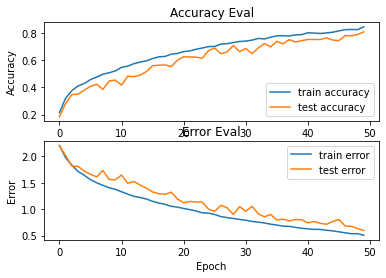

In [22]:
inputs_train,inputs_test,targets_train,targets_test=train_test_split(inputs,targets,test_size=0.3)
inputs_train,inputs_validation,targets_train,targets_validation=train_test_split(inputs_train,targets_train,test_size=0.2)
inputs_train=inputs_train[...,np.newaxis]
inputs_test=inputs_test[...,np.newaxis]
inputs_validation=inputs_validation[...,np.newaxis]
inputs_shape=(inputs_train.shape[1],inputs_train.shape[2],inputs_train.shape[3])

model_CRNN=CRNN2D(inputs_shape)

history=model_CRNN.fit(inputs_train,targets_train,
          validation_data=(inputs_validation,targets_validation),
          epochs=50,
          batch_size=16,
          )
plot_history(history)


In [28]:
sample = ("/content/drive/MyDrive/Colab Notebooks/SummerProject/audio/shopping_mall-milan-1084-41353-a.wav")
predict_sample(sample,model_CRNN)

shopping_mall
